
# IceVision Bboxes - CycleGAN Data

*This is a mashup of IceVision's "[Custom Parser](https://airctic.com/0.8.0/custom_parser/)" example and their ["Getting Started (Object Detection)"](https://airctic.com/0.8.0/getting_started_object_detection/) notebooks, to analyze SPNet Real dataset, for which I [generated bounding boxes](https://github.com/drscotthawley/SPNet/blob/master/gen_bboxes_csv.py). -- S.H. Hawley, July 1, 2021*

## Installing IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

In [ ]:
# IceVision - IceData - MMDetection - YOLO v5 Installation
#try:
#    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
#    !chmod +x install_colab.sh && ./install_colab.sh
#except:
#    print("Ignore the error messages and just keep going")

In [ ]:
#all_slow

In [ ]:
# For Icevision Install of MMD.  cf. https://airctic.com/0.8.1/install/
import torch, re 
tv, cv = torch.__version__, torch.version.cuda
tv = re.sub('\+cu.*','',tv)
TORCH_VERSION = 'torch'+tv[0:-1]+'0'
CUDA_VERSION = 'cu'+cv.replace('.','')

print(f"TORCH_VERSION={TORCH_VERSION}; CUDA_VERSION={CUDA_VERSION}")

!pip install -qq mmcv-full=="1.3.8" -f https://download.openmmlab.com/mmcv/dist/{CUDA_VERSION}/{TORCH_VERSION}/index.html --upgrade
!pip install mmdet -qq

TORCH_VERSION=torch1.8.0; CUDA_VERSION=cu102


## Imports
As always, let's import everything from `icevision`. Additionally, we will also need `pandas` (you might need to install it with `pip install pandas`).

In [ ]:
from icevision.all import *
import pandas as pd

INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

## Download dataset

We're going to be using a small sample of the chess dataset, the full dataset is offered by roboflow [here](https://public.roboflow.com/object-detection/chess-full)

In [ ]:
# clear out the old version of the data
!rm -rf  /root/.icevision/data/espiownage-cyclegan

rm: cannot remove '/root/.icevision/data/espiownage-cyclegan': Permission denied


In [ ]:
#data_url = "https://github.com/airctic/chess_sample/archive/master.zip"
#data_dir = icedata.load_data(data_url, 'chess_sample') / 'chess_sample-master'

# SPNET Real Dataset link (currently proprietary, thus link may not work)
#data_url = "https://hedges.belmont.edu/~shawley/spnet_sample-master.zip"
#data_dir = icedata.load_data(data_url, 'spnet_sample') / 'spnet_sample-master' 

# espiownage cyclegan dataset:
data_url = 'https://hedges.belmont.edu/~shawley/espiownage-cyclegan.tgz'
data_dir = icedata.load_data(data_url, 'espiownage-cyclegan') / 'espiownage-cyclegan'

## Understand the data format

In this task we were given a `.csv` file with annotations, let's take a look at that.

!!! danger "Important"  
    Replace `source` with your own path for the dataset directory.

In [ ]:
df = pd.read_csv(data_dir / "bboxes/annotations.csv")
df.head()

filename  width  height  label  xmin  ymin  xmax  ymax
0  steelpan_0000000.png    512     384     10   130   114   265   281
1  steelpan_0000000.png    512     384      4   272    37   377   178
2  steelpan_0000000.png    512     384     10   415   292   480   353
3  steelpan_0000000.png    512     384     10    36    21   109   158
4  steelpan_0000002.png    512     384      2   100   161   163   218

At first glance, we can make the following assumptions:  

  * Multiple rows with the **same** filename, width, height  
  * A **label** for each row
  * A **bbox** [xmin, ymin, xmax, ymax] for each row  
  
Once we know what our data provides we can create our custom `Parser`.  

In [ ]:
set(np.array(df['label']).flatten())

{2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22}

In [ ]:
#df['label'] =  "_"+df['label'].apply(str)   # force label to be string-like
#df['label'] = ["Object"]*len(df)#  "_"+df['label'].apply(str)   # force label to be string-like

In [ ]:
df['label'] /= 2
#df.head()
df['label'] = df['label'].apply(int) 
print(set(np.array(df['label']).flatten()))
df['label'] = "_"+df['label'].apply(str)+"_"

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


In [ ]:
df.head()

filename  width  height label  xmin  ymin  xmax  ymax
0  steelpan_0000000.png    512     384   _5_   130   114   265   281
1  steelpan_0000000.png    512     384   _2_   272    37   377   178
2  steelpan_0000000.png    512     384   _5_   415   292   480   353
3  steelpan_0000000.png    512     384   _5_    36    21   109   158
4  steelpan_0000002.png    512     384   _1_   100   161   163   218

In [ ]:
# ***OR*** we can just make them all the same object:
df['label'] = 'AN'  # antinode
df.head()

filename  width  height label  xmin  ymin  xmax  ymax
0  steelpan_0000000.png    512     384    AN   130   114   265   281
1  steelpan_0000000.png    512     384    AN   272    37   377   178
2  steelpan_0000000.png    512     384    AN   415   292   480   353
3  steelpan_0000000.png    512     384    AN    36    21   109   158
4  steelpan_0000002.png    512     384    AN   100   161   163   218

## Create the Parser

The first step is to create a template record for our specific type of dataset, in this case we're doing standard object detection:

In [ ]:
template_record = ObjectDetectionRecord()

Now use the method `generate_template` that will print out all the necessary steps we have to implement.

In [ ]:
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_img_size(<ImgSize>)
        record.set_filepath(<Union[str, Path]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)
        record.detection.add_bboxes(<Sequence[BBox]>)


We can copy the template and use it as our starting point. Let's go over each of the methods we have to define:

- `__init__`: What happens here is completely up to you, normally we have to pass some reference to our data, `data_dir` in our case.

- `__iter__`: This tells our parser how to iterate over our data, each item returned here will be passed to `parse_fields` as `o`. In our case we call `df.itertuples` to iterate over all `df` rows.

- `__len__`: How many items will be iterating over.

- `imageid`: Should return a `Hashable` (`int`, `str`, etc). In our case we want all the dataset items that have the same `filename` to be unified in the same record.

- `parse_fields`: Here is where the attributes of the record are collected, the template will suggest what methods we need to call on the record and what parameters it expects. The parameter `o` it receives is the item returned by `__iter__`.

!!! danger "Important"  
    Be sure to pass the correct type on all record methods!

In [ ]:
# IceVision excample used "ChessParser" for chess data. For SPNet we could rename this class
# but currently not a priority!
class ChessParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "bboxes/annotations.csv")
        #self.df['label'] /= 2
        #self.df['label'] = self.df['label'].apply(int) 
        #self.df['label'] = "_"+self.df['label'].apply(str)+"_"
        self.df['label'] = 'AN'  # make them all the same object
        self.class_map = ClassMap(list(self.df['label'].unique()))
        
    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o
        
    def __len__(self) -> int:
        return len(self.df)
        
    def record_id(self, o) -> Hashable:
        return o.filename
        
    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / 'images' / o.filename)
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)
        
        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

Let's randomly split the data and parser with `Parser.parse`:

In [ ]:
parser = ChessParser(template_record, data_dir)

In [ ]:
train_records, valid_records = parser.parse()

  0%|          | 0/3676 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/832 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Let's take a look at one record:

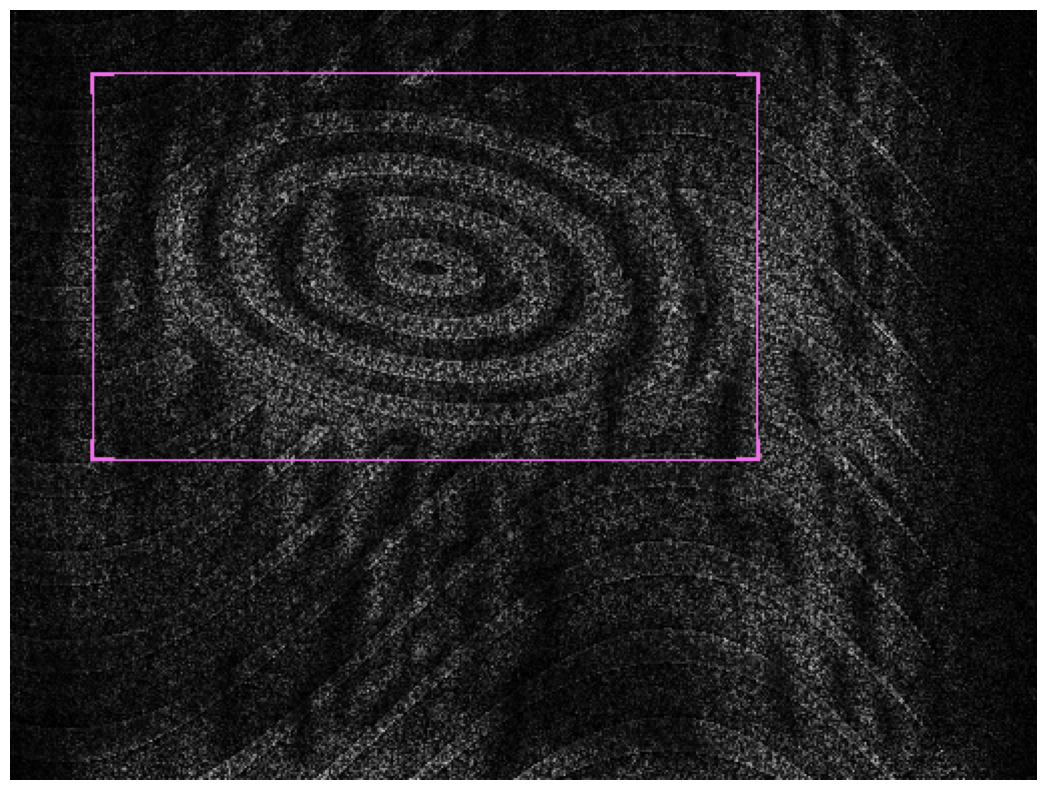

In [ ]:
show_record(train_records[5], display_label=False, figsize=(14, 10))

In [ ]:
train_records[0]

BaseRecord

common: 
	- Record ID: 500
	- Image size ImgSize(width=512, height=384)
	- Filepath: /home/shawley/.icevision/data/espiownage-cyclegan/espiownage-cyclegan/images/steelpan_0000582.png
	- Img: None
detection: 
	- Class Map: <ClassMap: {'background': 0, 'AN': 1}>
	- Labels: [1]
	- BBoxes: [<BBox (xmin:107, ymin:41, xmax:274, ymax:190)>]

## Moving On...
*Following the Getting Started "refrigerator" notebook...*

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384  
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### this next cell generates an error. ignore it and move on

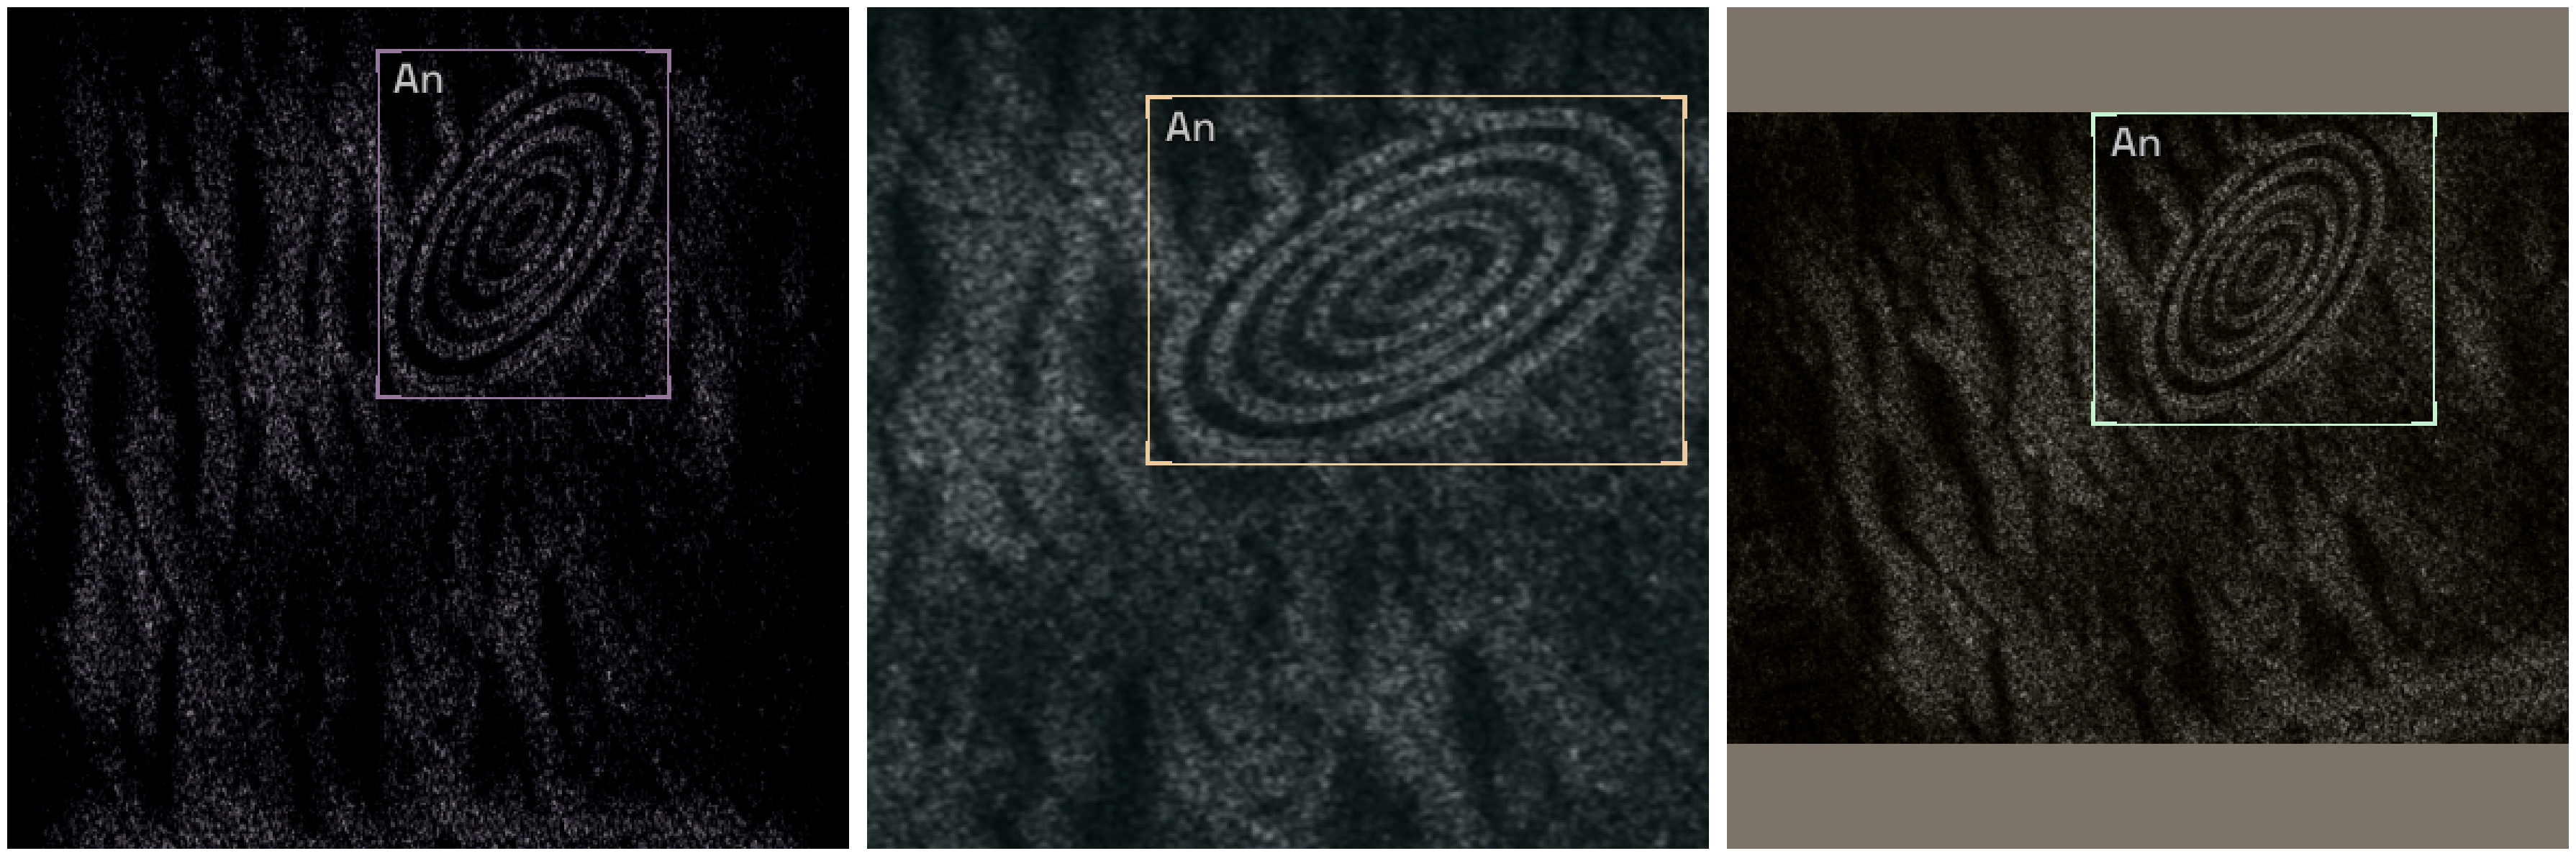

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [ ]:
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)

In [ ]:
# Just change the value of selection to try another model

selection = 0


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.retinanet' from '/home/shawley/envs/icevision/lib/python3.8/site-packages/icevision/models/mmdet/models/retinanet/__init__.py'>,
 {})

In [ ]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

  0%|          | 0/152149505 [00:00<?, ?B/s]

/home/shawley/envs/icevision/lib/python3.8/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([9, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([9]).


In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [ ]:
# show batch
#model_type.show_batch(first(valid_dl), ncols=4)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
#i'm more familiar with fastai than lighting, so we'll use the fastai bindings

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/home/shawley/envs/icevision/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/shawley/envs/icevision/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=9.120108734350652e-05)

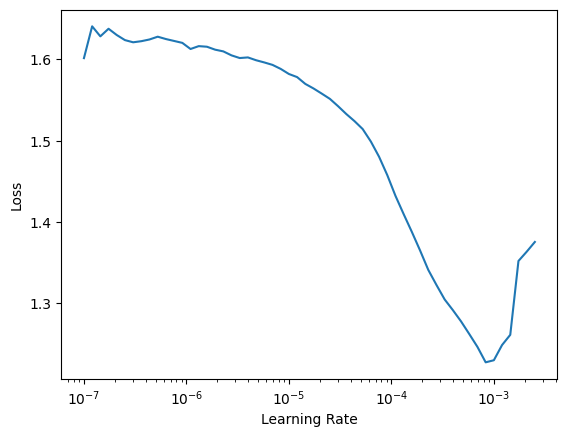

In [ ]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [ ]:
learn.fine_tune(60, 1e-4, freeze_epochs=2)

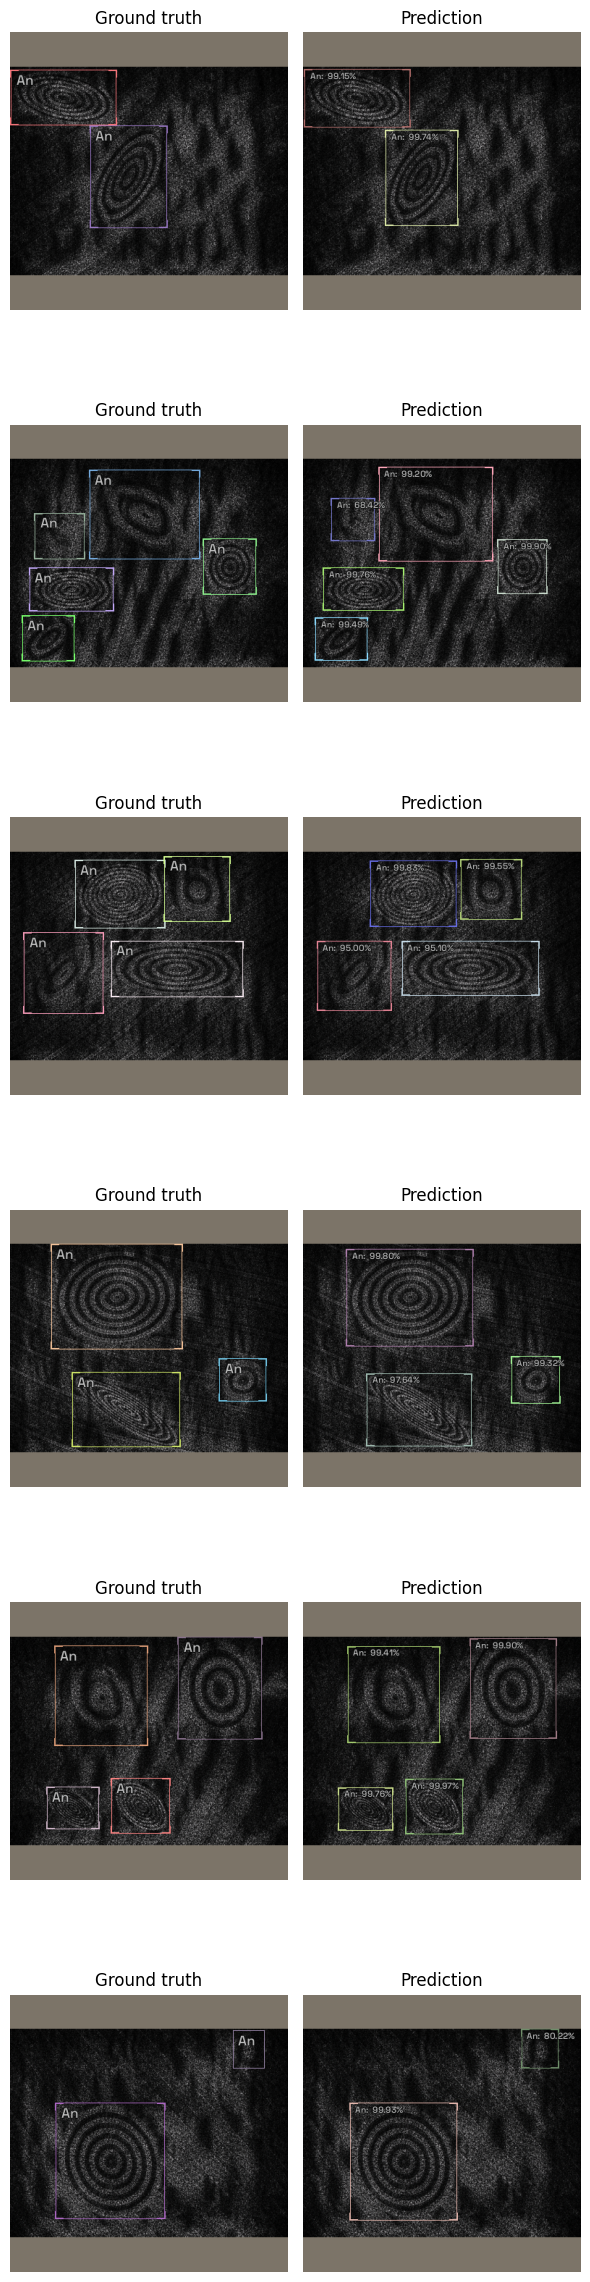

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

## Next steps

- This was just merged, come help us adjusting the documentation and fixing the bugs

## Conclusion

And that's it! Now that you have your data in the standard library record format, you can use it to create a `Dataset`, visualize the image with the annotations and basically use all helper functions that IceVision provides! 

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).